In [1]:
import os
import shutil
import random
import math
from PIL import Image, ImageOps, ImageFilter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import kagglehub
import matplotlib.pyplot as plt

from warnings import filterwarnings
from IPython.display import clear_output
from tqdm import tqdm

filterwarnings('ignore')


In [18]:
ROOT_DIR = "drive/MyDrive/Colab/170"

def save_to_drive(filepath, folder=''):
    if folder == '':
        !cp -r $filepath $ROOT_DIR/
    else:
        !cp -r $filepath $ROOT_DIR/$folder/

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [6]:
'''
#####
Adapted from https://github.com/facebookresearch/barlowtwins
and mostly taken from https://github.com/MaxLikesMath/Barlow-Twins-Pytorch
#####
'''

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


class TransformFirst:
    def __init__(self, transform=None):
        if transform == None:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __call__(self, x):
        return self.transform(x)

class TransformSecond:
    def __init__(self, transform=None):
        if transform == None:

            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __call__(self, x):
        return self.transform(x)

class Transform:
    def __init__(self, transform=None, transform_prime=None):
        '''

        :param transform: Transforms to be applied to first input
        :param transform_prime: transforms to be applied to second
        '''
        if transform == None:
            self.transform = TransformFirst()
        else:
            self.transform = transform
        if transform_prime == None:
            self.transform_prime = TransformSecond()
        else:
            self.transform_prime = transform_prime

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return torch.cat((y1.unsqueeze(0), y2.unsqueeze(0)))


In [26]:
class Metrics:
    def f1_score(output, target):
        '''
        Вычисляет f1-score модели
        '''
        preds = torch.where(output > 0.5, 1, 0).to(output.device)
        TP = torch.sum(preds * target)
        FP = torch.sum(preds * (1 - target))
        FN = torch.sum((1 - preds) * target)
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        return f1.item()

    def precision(output, target):
        """
        Вычисляет precision (точность) модели.
        """
        preds = torch.where(output > 0.5, 1, 0).to(output.device)
        TP = torch.sum(preds * target)
        FP = torch.sum(preds * (1 - target))
        FN = torch.sum((1 - preds) * target)
        precision = TP / (TP + FP + 1e-8)
        return precision.item()

    def recall(output, target):
        """
        Вычисляет recall (полноту) модели.
        """
        preds = torch.where(output > 0.5, 1, 0).to(output.device)
        TP = torch.sum(preds * target)
        FP = torch.sum(preds * (1 - target))
        FN = torch.sum((1 - preds) * target)
        recall = TP / (TP + FN + 1e-8)
        return recall.item()

    def roc_auc_score(output, target):
        """
        Вычисляет ROC-AUC score модели.
        """
        outputs_np = output.detach().cpu().numpy()
        targets_np = target.detach().cpu().numpy()
        return roc_auc_score(targets_np, outputs_np)


In [27]:
'''
Implementation of Barlow Twins (https://arxiv.org/abs/2103.03230), adapted for ease of use for experiments from
https://github.com/facebookresearch/barlowtwins, with some modifications using code from
https://github.com/lucidrains/byol-pytorch

Mostly taken from https://github.com/MaxLikesMath/Barlow-Twins-Pytorch
'''

def flatten(t):
    return t.reshape(t.shape[0], -1)

class NetWrapper(nn.Module):
    # from https://github.com/lucidrains/byol-pytorch
    def __init__(self, net, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.hidden = None
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, __, output):
        self.hidden = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        _ = self.net(x)
        hidden = self.hidden
        self.hidden = None
        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x):
        representation = self.get_representation(x)

        return representation


def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class BarlowTwins(nn.Module):
    '''
    Adapted from https://github.com/facebookresearch/barlowtwins for arbitrary backbones, and arbitrary choice of which
    latent representation to use. Designed for models which can fit on a single GPU (though training can be parallelized
    across multiple as with any other model). Support for larger models can be done easily for individual use cases
    by following PyTorch's model parallelism best practices.
    '''
    def __init__(self, backbone, latent_id, projection_sizes, lambd, scale_factor=1):
        '''

        :param backbone: Model backbone
        :param latent_id: name (or index) of the layer to be fed to the projection MLP
        :param projection_sizes: size of the hidden layers in the projection MLP
        :param lambd: tradeoff function
        :param scale_factor: Factor to scale loss by, default is 1
        '''
        super().__init__()
        self.backbone = backbone
        self.backbone = NetWrapper(self.backbone, latent_id)
        self.lambd = lambd
        self.scale_factor = scale_factor

        # projector
        sizes = projection_sizes
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        if len(sizes) >= 2:
          layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

        # pairwise similarity net
        self.sim = nn.Sequential(
            nn.Linear(sizes[-1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward_projection(self, y1, y2):
        z1 = self.backbone(y1)
        z2 = self.backbone(y2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)

        # empirical cross-correlation matrix
        c = torch.mm(self.bn(z1).T, self.bn(z2))
        c.div_(z1.shape[0])

        # use --scale-loss to multiply the loss by a constant factor
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = self.scale_factor*(on_diag + self.lambd * off_diag)
        return loss

    def forward(self, y1, y2):
        z1 = self.backbone(y1)
        z2 = self.backbone(y2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)

        return self.sim(torch.cat((z1, z2), dim=1)).squeeze(1)

    def adjust_learning_rate(self, optimizer, epoch, epochs):
        start_lr = 3e-3
        end_lr = 3e-4

        coef = 0.5 * (1 + math.cos(math.pi * epoch / epochs))
        lr = start_lr * coef + end_lr * (1 - coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def train_projector(self, train_dataloader, validation_dataloader,
                   optimizer, epochs=10, plot=True):
        '''
        Training projector with frozen backbone's weights

        train_dataloader: dataloader for train samples
        validation_dataloader: dataloader for validation samples
        optimizer: gradient descent optimizer
        '''
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        print("Training on", device)
        self.backbone.requires_grad_(False)
        self.projector.requires_grad_(True)
        self.sim.requires_grad_(False)
        train_losses = []
        validation_losses = []
        for epoch in tqdm(range(epochs)):
            total_train_loss = 0
            for batch_idx, x in enumerate(train_dataloader):
                x = x.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                loss = self.forward_projection(x1, x2)
                total_train_loss = (total_train_loss * batch_idx + loss.item()) / (batch_idx + 1)
                self.adjust_learning_rate(optimizer, epoch, epochs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_validation_loss = 0
            for batch_idx, x in enumerate(validation_dataloader):
                x = x.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                loss = self.forward_projection(x1, x2)
                total_validation_loss = (total_validation_loss * batch_idx + loss.item()) / (batch_idx + 1)

            if epoch == 0:
                continue

            train_losses.append(total_train_loss)
            validation_losses.append(total_validation_loss)

            if plot:
                clear_output()
                plt.figure(figsize=(10, 6))
                plt.title("Training Projector")
                plt.plot(train_losses, color='blue', label="train")
                plt.plot(validation_losses, color='orange', label="validation")
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.grid(True)
                plt.legend()
                plt.show()

        return train_losses, validation_losses

    def train_similarity_net(self, train_dataloader, validation_dataloader,
                   optimizer, epochs=10, plot=True):
        '''
        Training similarity net with whole model frozen

        train_dataloader: dataloader for train samples
        validation_dataloader: dataloader for validation samples
        optimizer: gradient descent optimizer
        '''
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        print("Training on", device)
        self.backbone.requires_grad_(False)
        self.projector.requires_grad_(False)
        self.sim.requires_grad_(True)
        criterion = nn.BCELoss()
        train_losses = []
        train_acc = []
        validation_losses = []
        validation_acc = []
        for epoch in tqdm(range(epochs)):
            total_train_loss = 0
            mean_train_acc = 0
            for batch_idx, (x, target) in enumerate(train_dataloader):
                x = x.to(device)
                target = target.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                prob = self(x1, x2)
                loss = criterion(prob, target)
                total_train_loss = (total_train_loss * batch_idx + loss.item()) / (batch_idx + 1)
                mean_train_acc = (mean_train_acc * batch_idx + Metrics.f1_score(prob, target)) / (batch_idx + 1)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_validation_loss = 0
            mean_validation_acc = 0
            for batch_idx, (x, target) in enumerate(validation_dataloader):
                x = x.to(device)
                target = target.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                prob = self(x1, x2)
                loss = criterion(prob, target)
                total_validation_loss = (total_validation_loss * batch_idx + loss.item()) / (batch_idx + 1)
                mean_validation_acc = (mean_validation_acc * batch_idx + Metrics.f1_score(prob, target)) / (batch_idx + 1)

            if epoch == 0:
                continue

            train_losses.append(total_train_loss)
            validation_losses.append(total_validation_loss)
            train_acc.append(mean_train_acc)
            validation_acc.append(mean_validation_acc)

            if plot:
                clear_output()
                plt.figure(figsize=(14, 6))
                plt.suptitle("Training Similarity Net")

                plt.subplot(1, 2, 1)
                plt.plot(train_losses, color='blue', label="train")
                plt.plot(validation_losses, color='orange', label="validation")
                plt.xlabel('Epoch')
                plt.ylabel('BCE Loss')
                plt.grid(True)
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(train_acc, color='blue', label="train")
                plt.plot(validation_acc, color='orange', label="validation")
                plt.xlabel('Epoch')
                plt.ylabel('F1 Score')
                plt.grid(True)
                plt.legend()
                plt.show()

        return train_losses, validation_losses, train_acc, validation_acc


In [28]:
class ImageDataset(Dataset):
    '''
    Simple torch dataset class for images
    '''
    def __init__(self, image_array, transform=None):
        self.image_array = image_array
        self.transform = transform

    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.image_array[idx])
        return self.image_array[idx]

class RandomPairImageDataset(Dataset):
    '''
    Dataset which returns a random pair of images
    '''
    def __init__(self, image_array, transform_first=None, transform_second=None, same_prob=0.5):
        '''
        transform_first: transform for first image
        transform_second: transform for second image
        same_prob: probability of returning first_image == second_image
                   before transformations
        '''
        self.image_array = image_array
        self.transform_first = transform_first
        self.transform_second = transform_second
        self.same_prob = same_prob

    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        first_img = self.image_array[idx]
        same_img = 0
        if random.random() < self.same_prob:
            second_img = first_img
            same_img = 1
        else:
            second_img = random.choice(self.image_array)
        if self.transform_first:
            first_img = self.transform_first(first_img)
        if self.transform_second:
            second_img = self.transform_second(second_img)
        return (torch.cat((first_img.unsqueeze(0), second_img.unsqueeze(0))), torch.tensor(same_img).float())

def load_images(folder_path, count):
    '''
    Loads images from the folder
    and store them as a list of PIL images
    '''
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
        if len(images) == count:
            break
    return images

def load_dataset(folder_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = []
    folder_path = ROOT_DIR + "/" + folder_path
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
    return images


In [29]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

barlow_twins = BarlowTwins(resnet_model, 'avgpool', [2048, 1024, 1024, 1024],
                      3.9e-3, 1)


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


## Experiment: Small Dataset

Training: 500 images

Vailidation: 122 images


In [30]:
images = load_dataset("dataset_small")
random.shuffle(images)

train_size = 500

for i in range(len(images)):
    images[i] = to_pil_image(images[i])

train = images[:train_size]
validation = images[train_size:]

proj_train_dataset = ImageDataset(train,
                       transform=Transform())
proj_validation_dataset = ImageDataset(validation,
                       transform=Transform())

sim_train_dataset = RandomPairImageDataset(train,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)
sim_validation_dataset = RandomPairImageDataset(validation,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)

proj_train_dataloader = DataLoader(proj_train_dataset, batch_size=64, shuffle=True)
proj_validation_dataloader = DataLoader(proj_validation_dataset, batch_size=32, shuffle=True)

sim_train_dataloader = DataLoader(sim_train_dataset, batch_size=64, shuffle=True)
sim_validation_dataloader = DataLoader(sim_validation_dataset, batch_size=32, shuffle=True)


### Training projector (150 epochs)


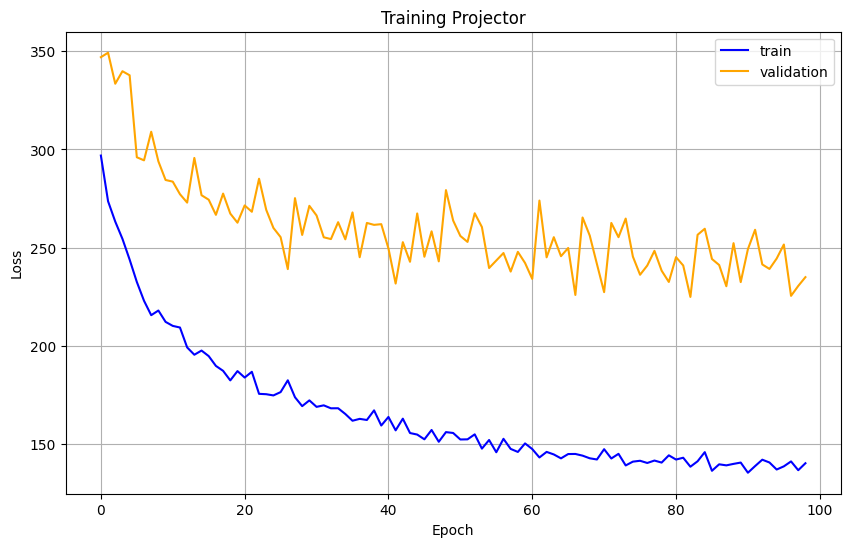

100%|██████████| 100/100 [22:10<00:00, 13.30s/it]


In [31]:
optimizer = torch.optim.Adam(barlow_twins.parameters())

proj_train_losses, proj_validation_losses = barlow_twins.train_projector(
    proj_train_dataloader,
    proj_validation_dataloader,
    optimizer,
    epochs=100
)


### Training similarity net (100 epochs)


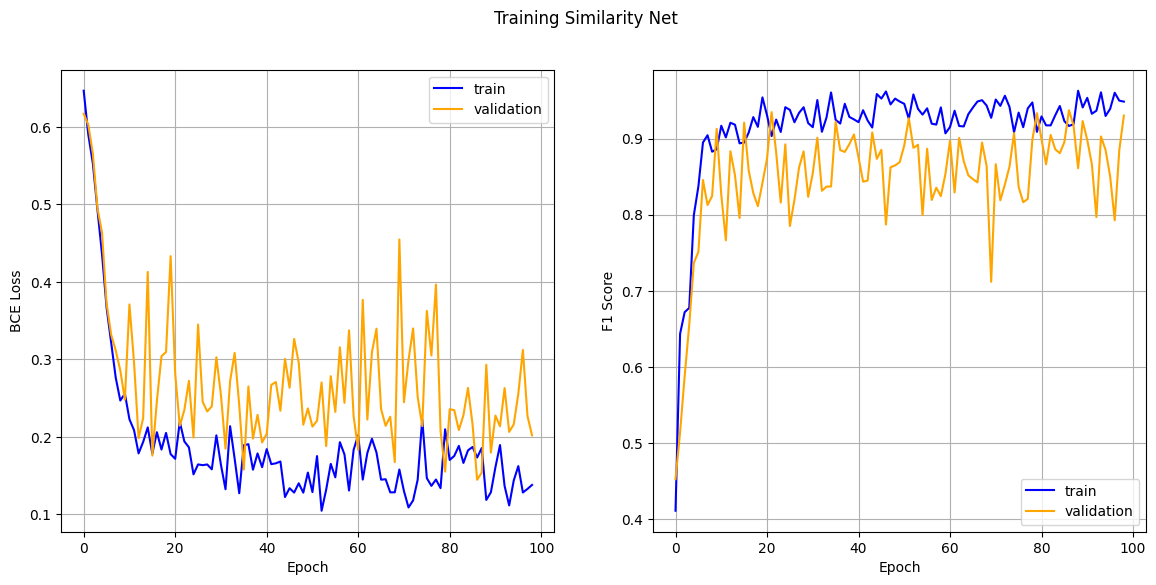

100%|██████████| 100/100 [22:15<00:00, 13.35s/it]


In [32]:
optimizer = torch.optim.Adam(barlow_twins.parameters(), lr=3e-4)

sim_train_losses, sim_validation_losses, train_acc, validation_acc = barlow_twins.train_similarity_net(
    sim_train_dataloader,
    sim_validation_dataloader,
    optimizer,
    epochs=100
)


### Saving model weights and learning info

In [33]:

def save_model_and_learning_stat(dataname, folder):
    '''
    Saving model weights and learning statistics
    '''
    torch.save(barlow_twins.state_dict(), dataname + ".pth")

    folder = "models/" + folder

    np.save(dataname + "__proj_train_loss.npy", proj_train_losses)
    np.save(dataname + "__proj_validation_loss.npy", proj_validation_losses)
    #np.save(dataname + "__sim_train_loss.npy", sim_train_losses)
    #np.save(dataname + "__sim_validation_loss.npy", sim_validation_losses)
    #np.save(dataname + "__train_acc.npy", train_acc)
    #np.save(dataname + "__validation_acc.npy", validation_acc)

    save_to_drive(dataname + ".pth", folder=folder)
    save_to_drive(dataname + "__proj_train_loss.npy", folder=folder)
    save_to_drive(dataname + "__proj_validation_loss.npy", folder=folder)
    #save_to_drive(dataname + "__sim_train_loss.npy", folder=folder)
    #save_to_drive(dataname + "__sim_validation_loss.npy", folder=folder)
    #save_to_drive(dataname + "__train_acc.npy", folder=folder)
    #save_to_drive(dataname + "__validation_acc.npy", folder=folder)


In [34]:
save_model_and_learning_stat("BT_small_proj100ep-sim100ep", folder='BT_small')

## Calculating accuracy metrics

In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
barlow_twins = BarlowTwins(resnet_model, 'avgpool', [2048, 1024, 1024, 1024],
                      3.9e-3, 1)
barlow_twins.load_state_dict(torch.load(ROOT_DIR + "/models/BT_small/BT_small_proj150ep-sim100ep.pth",
                                        map_location=torch.device("cpu")))
barlow_twins.to(device)


In [35]:
#images = load_dataset("dataset_small")

#for i in range(len(images)):
#    images[i] = to_pil_image(images[i])

#blood_cells_validation = images[-512:]

validation_dataset = RandomPairImageDataset(validation,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)

validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=True)


In [36]:
all_outputs = []
all_targets = []

for inputs, targets in tqdm(validation_dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)
    x1 = inputs[:, 0, :, :, :]
    x2 = inputs[:, 1, :, :, :]

    outputs = barlow_twins(x1, x2)

    all_outputs.append(outputs.detach().cpu())
    all_targets.append(targets.detach().cpu())

all_outputs = torch.cat(all_outputs)
all_targets = torch.cat(all_targets)


100%|██████████| 16/16 [00:02<00:00,  5.59it/s]


F1-score: 0.8421
Precision: 0.8696
Recall: 0.8163


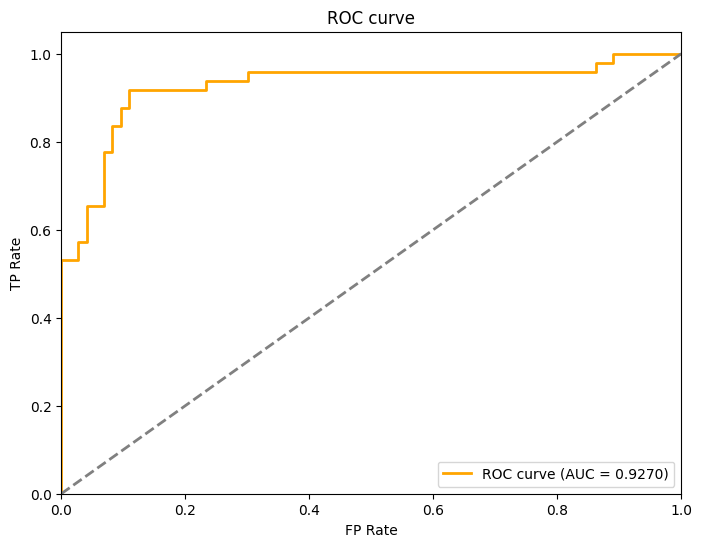

In [37]:
f1_score = Metrics.f1_score(all_outputs, all_targets)
precision = Metrics.precision(all_outputs, all_targets)
recall = Metrics.recall(all_outputs, all_targets)

fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
roc_auc = auc(fpr, tpr)

print(f"F1-score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

In [ ]:
'''
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.4f}' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=14)
plt.ylabel('TP Rate', fontsize=14)
plt.title('ROC curve', fontsize=14)
plt.tick_params(labelsize=12)

plt.legend(loc="lower right")
plt.legend(loc="lower right", fontsize=14)
plt.show()
'''